# Nome: Raylander Marques Melo
# Matrícula: 586108

## Questão 1: Considere o conjunto de dados disponível em breastcancer.csv, organizado em 31 colunas, sendo as 30 primeiras colunas os atributos e a última coluna a saída. Os 30 atributos coletados de exames médicos são usados no diagnóstico do câncer de mama, sendo 1 a classe positiva e 0 a classe negativa. Maiores detalhes sobre os dados podem ser conferidos em https://scikit-learn.org/ stable/datasets/toy_dataset.html#breast-cancer-dataset.

In [1]:
!pip install numpy

  Using cached numpy-2.2.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.1 MB)


In [1]:
import numpy as np

In [14]:
# Carregar o conjunto de dados breast cancer
cancer_dataset = np.loadtxt('breastcancer.csv', delimiter=',', skiprows=1)
# Printar o conjunto de dados
cancer_dataset

array([[2.057e+01, 1.777e+01, 1.329e+02, ..., 2.750e-01, 8.902e-02,
        1.000e+00],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 3.613e-01, 8.758e-02,
        1.000e+00],
       [1.142e+01, 2.038e+01, 7.758e+01, ..., 6.638e-01, 1.730e-01,
        1.000e+00],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 2.218e-01, 7.820e-02,
        1.000e+00],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 4.087e-01, 1.240e-01,
        1.000e+00],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 2.871e-01, 7.039e-02,
        0.000e+00]], shape=(568, 31))

In [71]:
# Adiciona uma coluna de 1s para o termo de bias
def adicionar_bias(X):
    # Armazena a quantidade de linhas do dataset
    n = X.shape[0]
    # Retorna a matriz X com uma coluna de 1s adicionada
    return np.hstack((np.ones((n, 1)), X))

In [3]:
def normaliza(X):
    # Calculando a média e a distribuição 
    mean = X.sum(axis = 0) / X.shape[0]
    std = np.sqrt(((X-mean)**2).sum(axis=0)/(X.shape[0]-1))
    # Normaliza os dados
    return (X - mean / std), mean, std

In [5]:
def sigmoid(z):
    # Calcula a função sigmoide
    return 1 / (1 + np.exp(-z))

In [6]:
def kfold(X, y, k):
    # Embaralha os dados
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    # Divide os dados em k folds
    folds = np.array_split(indices, k)
    
    for i in range(k):
        # Cria os conjuntos de treino e teste
        test_indices = folds[i]
        train_indices = np.concatenate(folds[:i] + folds[i+1:])
        
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        
        yield X_train, X_test, y_train, y_test


In [7]:
def predict(theta, X):
    # Faz previsões com base nos parâmetros theta
    probabilidade = sigmoid(X @ theta)
    # Converte as probabilidades em classes
    return (probabilidade >= 0.5).astype(int)

### Questão 1 a) Considerando uma validação cruzada em 10 folds, avalie modelos de classificação binária nos dados em questão. Para tanto, use as abordagens abaixo:


### Questão 1 b) Para cada modelo criado, reporte valor médio e desvio padrão da acurácia global e da acurácia por classe.

###  – Regressão logística (treinado com GD ou SGD);

In [274]:
def funcao_custo(theta, X, y):
    # Calcula a função de custo
    m = X.shape[0]
    h = sigmoid(X @ theta)

    # Evita log(0) forçando os valores a ficarem no intervalo (1e-10, 1 - 1e-10)
    epsilon = 1e-6 
    h = np.clip(h, epsilon, 1 - epsilon)

    return (-1/m) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))

In [273]:
def gradiente_descendente(theta, X, y, alpha, num_iter):
    # Inicializa o vetor de custos
    custo = np.zeros(num_iter)
    m = X.shape[0]
    
    for i in range(num_iter):
        # Calcula a função sigmoide
        h = sigmoid(X @ theta)
        # Atualiza os parâmetros theta
        theta -= (alpha/m) * (X.T @ (h - y))
        # Armazena o custo
        custo[i] = funcao_custo(theta, X, y)
    
    return theta, custo

In [272]:
def cross_validation(X, y, k, alpha, num_iter):
    acuracias_globais = []
    acuracias_por_classe = []
    custos = []
    
    for X_train, X_test, y_train, y_test in kfold(X, y, k):

        # Normaliza os dados
        X_train, mean, std = normaliza(X_train)
        X_test, mean, std = normaliza(X_test)

        # Adiciona o bias
        X_train = adicionar_bias(X_train)
        X_test = adicionar_bias(X_test)

         # Inicializa os pesos
        theta = np.zeros(X_train.shape[1])
        
        # Treina o modelo
        theta, custo = gradiente_descendente(theta, X_train, y_train, alpha, num_iter)
        
        # Faz previsões
        y_pred = predict(theta, X_test)

        custos.append(custo[-1])
        
       # Acurácia global
        acuracia_global = np.mean(y_pred == y_test)
        acuracias_globais.append(acuracia_global)

        # Acurácia por classe
        classes = np.unique(y)
        acuracias_classe = []
        for c in classes:
            idx = (y_test == c)
            acuracia_c = np.mean(y_pred[idx] == y_test[idx])
            acuracias_classe.append(acuracia_c)
        acuracias_por_classe.append(acuracias_classe)

      # Converte para array para facilitar operações
    acuracias_por_classe = np.array(acuracias_por_classe)

    # Calcula estatísticas
    media_global = np.mean(acuracias_globais)
    desvio_global = np.std(acuracias_globais)

    media_por_classe = np.mean(acuracias_por_classe, axis=0)
    desvio_por_classe = np.std(acuracias_por_classe, axis=0)    
        
    return np.mean(custos), np.std(custos), media_global, desvio_global, media_por_classe, desvio_por_classe, acuracias_globais

In [275]:
# Separa os dados em variáveis independentes e dependentes
X = cancer_dataset[:, :-1]
y = cancer_dataset[:, -1]

print(X.shape)
print(y.shape)

# Define os parâmetros
alpha = 0.01
num_iter = 1000
k = 10

# Executa a validação cruzada
media_custo, desvio_padrao_custo, media_g, desvio_g, media_classe, desvio_classe, acuracias_globais = cross_validation(X, y, k, alpha, num_iter)

print(f"Acurácia global média: {media_g:.4f}")
print(f"Desvio padrão da acurácia global: {desvio_g:.4f}")

print("\n")

for i, (m, d) in enumerate(zip(media_classe, desvio_classe)):
    print(f"Acurácia média e desvio padrão da classe {i}: {m:.4f} (± {d:.4f})")

print("\n")

for i, acuracia in enumerate(acuracias_globais):
    print(f"Acurácia global para o fold {i}: {acuracia:.4f}")

print("\n")

print(f'Média do custo: {media_custo}')
print(f'Desvio padrão do custo: {desvio_padrao_custo}')
print(f'Acurácia: {acuracia}')


(568, 30)
(568,)


/tmp/ipykernel_6937/1913084967.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Acurácia global média: 0.8538
Desvio padrão da acurácia global: 0.1422


Acurácia média e desvio padrão da classe 0: 0.8412 (± 0.2735)
Acurácia média e desvio padrão da classe 1: 0.8615 (± 0.1184)


Acurácia global para o fold 0: 0.8947
Acurácia global para o fold 1: 0.4561
Acurácia global para o fold 2: 0.8772
Acurácia global para o fold 3: 0.8947
Acurácia global para o fold 4: 0.8421
Acurácia global para o fold 5: 1.0000
Acurácia global para o fold 6: 0.9298
Acurácia global para o fold 7: 0.9649
Acurácia global para o fold 8: 0.8393
Acurácia global para o fold 9: 0.8393


Média do custo: 1.9616776885958687
Desvio padrão do custo: 1.9583124236146439
Acurácia: 0.8392857142857143


###  – Análise do discriminante Gaussiano;

In [8]:
!pip install scipy
from scipy.stats import shapiro

In [136]:
X = cancer_dataset[:, :-1]
for i in range(X.shape[1]):
    stat, p = shapiro(X[:, i])
    print(f"Feature {i}: p = {p:.4f} - {'Normal' if p > 0.05 else 'Não normal'}")


Feature 0: p = 0.0000 - Não normal
Feature 1: p = 0.0000 - Não normal
Feature 2: p = 0.0000 - Não normal
Feature 3: p = 0.0000 - Não normal
Feature 4: p = 0.0001 - Não normal
Feature 5: p = 0.0000 - Não normal
Feature 6: p = 0.0000 - Não normal
Feature 7: p = 0.0000 - Não normal
Feature 8: p = 0.0000 - Não normal
Feature 9: p = 0.0000 - Não normal
Feature 10: p = 0.0000 - Não normal
Feature 11: p = 0.0000 - Não normal
Feature 12: p = 0.0000 - Não normal
Feature 13: p = 0.0000 - Não normal
Feature 14: p = 0.0000 - Não normal
Feature 15: p = 0.0000 - Não normal
Feature 16: p = 0.0000 - Não normal
Feature 17: p = 0.0000 - Não normal
Feature 18: p = 0.0000 - Não normal
Feature 19: p = 0.0000 - Não normal
Feature 20: p = 0.0000 - Não normal
Feature 21: p = 0.0000 - Não normal
Feature 22: p = 0.0000 - Não normal
Feature 23: p = 0.0000 - Não normal
Feature 24: p = 0.0002 - Não normal
Feature 25: p = 0.0000 - Não normal
Feature 26: p = 0.0000 - Não normal
Feature 27: p = 0.0000 - Não normal
Fe

In [9]:
from scipy.stats import kstest

In [140]:
X = cancer_dataset[:, :-1]
for i in range(X.shape[1]):
    mean = np.mean(X)
    std = np.std(X)
    # Aplica o K-S Test comparando com a normal ajustada
    stat, p_value = kstest(X, 'norm', args=(mean, std))
    print(f"Feature {i}: p = {p:.4f} - {'Normal' if p > 0.05 else 'Não normal'}")

Feature 0: p = 0.0000 - Não normal
Feature 1: p = 0.0000 - Não normal
Feature 2: p = 0.0000 - Não normal
Feature 3: p = 0.0000 - Não normal
Feature 4: p = 0.0000 - Não normal
Feature 5: p = 0.0000 - Não normal
Feature 6: p = 0.0000 - Não normal
Feature 7: p = 0.0000 - Não normal
Feature 8: p = 0.0000 - Não normal
Feature 9: p = 0.0000 - Não normal
Feature 10: p = 0.0000 - Não normal
Feature 11: p = 0.0000 - Não normal
Feature 12: p = 0.0000 - Não normal
Feature 13: p = 0.0000 - Não normal
Feature 14: p = 0.0000 - Não normal
Feature 15: p = 0.0000 - Não normal
Feature 16: p = 0.0000 - Não normal
Feature 17: p = 0.0000 - Não normal
Feature 18: p = 0.0000 - Não normal
Feature 19: p = 0.0000 - Não normal
Feature 20: p = 0.0000 - Não normal
Feature 21: p = 0.0000 - Não normal
Feature 22: p = 0.0000 - Não normal
Feature 23: p = 0.0000 - Não normal
Feature 24: p = 0.0000 - Não normal
Feature 25: p = 0.0000 - Não normal
Feature 26: p = 0.0000 - Não normal
Feature 27: p = 0.0000 - Não normal
Fe

In [268]:
# Análise do descriminante Gaussiano
def gaussian_discriminant_analysis(X, y):
    m, n = X.shape
    # Calcula a média e a covariância
    mean = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)

    # Regularização
    cov += 1e-6 * np.eye(n)
    
    # Calcula a inversa da matriz de covariância
    cov_inv = np.linalg.inv(cov)
    
    # Calcula os parâmetros do modelo
    theta = cov_inv @ mean
    return theta

In [269]:
# Validação cruzada para GDA
def cross_validation_gda(X, y, k):
    acuracias_globais = []
    acuracias_por_classe = []
    
    for X_train, X_test, y_train, y_test in kfold(X, y, k):

        # Normaliza os dados
        X_train, mean, std = normaliza(X_train)
        X_test, mean, std = normaliza(X_test)

        # Adiciona o bias
        X_train = adicionar_bias(X_train)
        X_test = adicionar_bias(X_test)

         # Inicializa os pesos
        theta = np.zeros(X_train.shape[1])
        
        # Treina o modelo
        theta = gaussian_discriminant_analysis(X_train, y_train)
        
        # Faz previsões
        y_pred = predict(theta, X_test)
        
      # Acurácia global
        acuracia_global = np.mean(y_pred == y_test)
        acuracias_globais.append(acuracia_global)

        # Acurácia por classe
        classes = np.unique(y)
        acuracias_classe = []
        for c in classes:
            idx = (y_test == c)
            acuracia_c = np.mean(y_pred[idx] == y_test[idx])
            acuracias_classe.append(acuracia_c)
        acuracias_por_classe.append(acuracias_classe)

      # Converte para array para facilitar operações
    acuracias_por_classe = np.array(acuracias_por_classe)

    # Calcula estatísticas
    media_global = np.mean(acuracias_globais)
    desvio_global = np.std(acuracias_globais)

    media_por_classe = np.mean(acuracias_por_classe, axis=0)
    desvio_por_classe = np.std(acuracias_por_classe, axis=0)

    return media_global, desvio_global, media_por_classe, desvio_por_classe, acuracias_globais

In [270]:
# Separa os dados em variáveis independentes e dependentes
X = cancer_dataset[:, :-1]
y = cancer_dataset[:, -1]

# Define os parâmetros
k = 10

# Executa a validação cruzada
media_g, desvio_g, media_classe, desvio_classe, acuracias_globais = cross_validation_gda(X, y, k)

print(f"Acurácia global média: {media_g:.4f}")
print(f"Desvio padrão da acurácia global: {desvio_g:.4f}")

print("\n")

for i, (m, d) in enumerate(zip(media_classe, desvio_classe)):
    print(f"Acurácia média e desvio padrão da classe {i}: {m:.4f} (± {d:.4f})")

print("\n")

for i, acuracia in enumerate(acuracias_globais):
    print(f"Acurácia global para o fold {i}: {acuracia:.4f}")


Acurácia global média: 0.3717
Desvio padrão da acurácia global: 0.0715


Acurácia média e desvio padrão da classe 0: 0.0000 (± 0.0000)
Acurácia média e desvio padrão da classe 1: 1.0000 (± 0.0000)


Acurácia global para o fold 0: 0.4386
Acurácia global para o fold 1: 0.3333
Acurácia global para o fold 2: 0.3860
Acurácia global para o fold 3: 0.4561
Acurácia global para o fold 4: 0.2982
Acurácia global para o fold 5: 0.3333
Acurácia global para o fold 6: 0.3158
Acurácia global para o fold 7: 0.2982
Acurácia global para o fold 8: 0.5179
Acurácia global para o fold 9: 0.3393


###  – Naive Bayes Gaussiano;

In [142]:
!pip install matplotlib
!pip install seaborn

  Using cached matplotlib-3.10.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (104 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.2.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached contourpy-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (323 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.0-cp312-cp312-manylinux_2_5_x86_64

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

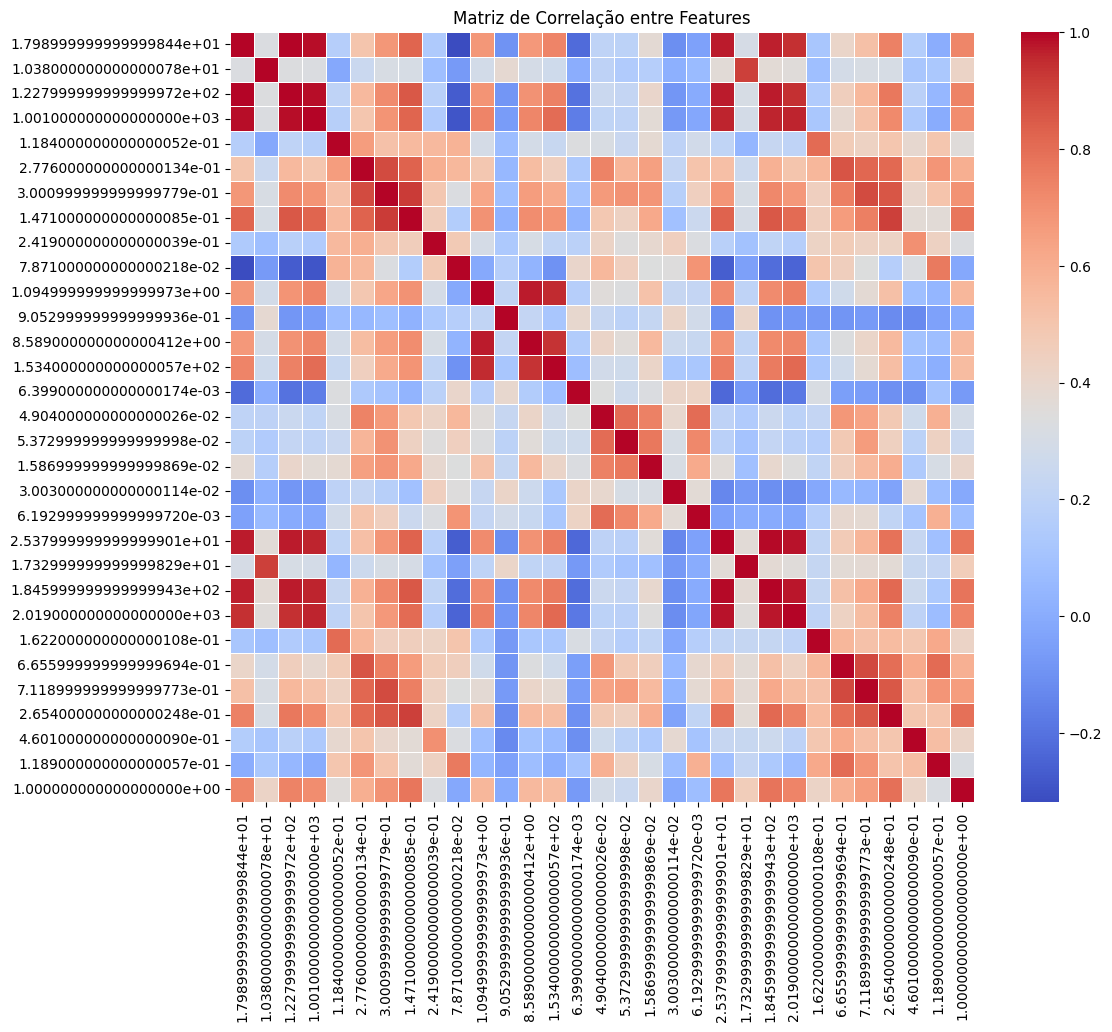

In [146]:
df = pd.read_csv('breastcancer.csv')

# Calcula a matriz de correlação
correlation_matrix = df.corr()

# Exibe como heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Matriz de Correlação entre Features")
plt.show()

In [147]:
# Extrai pares com correlação alta (mas diferentes de 1)
threshold = 0.8
corr_pairs = correlation_matrix.abs().unstack()
high_corr = corr_pairs[(corr_pairs > threshold) & (corr_pairs < 1)].sort_values(ascending=False)

print("Pares com correlação alta:")
print(high_corr)

Pares com correlação alta:
1.798999999999999844e+01  1.227999999999999972e+02    0.997876
1.227999999999999972e+02  1.798999999999999844e+01    0.997876
2.537999999999999901e+01  1.845999999999999943e+02    0.993814
1.845999999999999943e+02  2.537999999999999901e+01    0.993814
1.001000000000000000e+03  1.798999999999999844e+01    0.987344
                                                        ...   
4.904000000000000026e-02  6.192999999999999720e-03    0.802973
                          5.372999999999999998e-02    0.801183
5.372999999999999998e-02  4.904000000000000026e-02    0.801183
1.001000000000000000e+03  1.534000000000000057e+02    0.800829
1.534000000000000057e+02  1.001000000000000000e+03    0.800829
Length: 86, dtype: float64


In [11]:
# Naive Bayes Gaussiano
def gaussian_naive_bayes(X, y):
    m, n = X.shape
    # Calcula a média e a covariância
    mean = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)

    # Regularização
    cov += 1e-6 * np.eye(n)
    
    # Calcula a inversa da matriz de covariância
    cov_inv = np.linalg.inv(cov)
    
    # Calcula os parâmetros do modelo
    theta = cov_inv @ mean
    return theta

In [12]:
# Cross-validation para Naive Bayes
def cross_validation_naive_bayes(X, y, k):
    acuracias_globais = []
    acuracias_por_classe = []
    
    for X_train, X_test, y_train, y_test in kfold(X, y, k):

        # Normaliza os dados
        X_train, mean, std = normaliza(X_train)
        X_test, mean, std = normaliza(X_test)

        # Adiciona o bias
        X_train = adicionar_bias(X_train)
        X_test = adicionar_bias(X_test)

         # Inicializa os pesos
        theta = np.zeros(X_train.shape[1])
        
        # Treina o modelo
        theta = gaussian_naive_bayes(X_train, y_train)
        
        # Faz previsões
        y_pred = predict(theta, X_test)
        
        # Acurácia global
        acuracia_global = np.mean(y_pred == y_test)
        acuracias_globais.append(acuracia_global)

        # Acurácia por classe
        classes = np.unique(y)
        acuracias_classe = []
        for c in classes:
            idx = (y_test == c)
            acuracia_c = np.mean(y_pred[idx] == y_test[idx])
            acuracias_classe.append(acuracia_c)
        acuracias_por_classe.append(acuracias_classe)

      # Converte para array para facilitar operações
    acuracias_por_classe = np.array(acuracias_por_classe)

    # Calcula estatísticas
    media_global = np.mean(acuracias_globais)
    desvio_global = np.std(acuracias_globais)

    media_por_classe = np.mean(acuracias_por_classe, axis=0)
    desvio_por_classe = np.std(acuracias_por_classe, axis=0)

    return media_global, desvio_global, media_por_classe, desvio_por_classe, acuracias_globais

In [266]:
# Separa os dados em variáveis independentes e dependentes
X = cancer_dataset[:, :-1]
y = cancer_dataset[:, -1]

# Define os parâmetros
k = 10

# Executa a validação cruzada naive bayes
media_g, desvio_g, media_classe, desvio_classe, acuracias_globais = cross_validation_naive_bayes(X, y, k)

print(f"Acurácia global média: {media_g:.4f}")
print(f"Desvio padrão da acurácia global: {desvio_g:.4f}")

print("\n")

for i, (m, d) in enumerate(zip(media_classe, desvio_classe)):
    print(f"Acurácia média e desvio padrão da classe {i}: {m:.4f} (± {d:.4f})")

print("\n")

for i, acuracia in enumerate(acuracias_globais):
    print(f"Acurácia global para o fold {i}: {acuracia:.4f}")

Acurácia global média: 0.3714
Desvio padrão da acurácia global: 0.0422


Acurácia média e desvio padrão da classe 0: 0.0000 (± 0.0000)
Acurácia média e desvio padrão da classe 1: 1.0000 (± 0.0000)


Acurácia global para o fold 0: 0.3509
Acurácia global para o fold 1: 0.3509
Acurácia global para o fold 2: 0.3684
Acurácia global para o fold 3: 0.3333
Acurácia global para o fold 4: 0.4035
Acurácia global para o fold 5: 0.4386
Acurácia global para o fold 6: 0.3684
Acurácia global para o fold 7: 0.4035
Acurácia global para o fold 8: 0.2857
Acurácia global para o fold 9: 0.4107


## Questão 2: Considere o conjunto de dados disponível em vehicle.csv, organizado em 19 colunas, sendo as 18 primeiras colunas os atributos e a última coluna a saída. Os 18 atributos caracterizam a silhueta de veículos, extraídos pelo método HIPS (Hierarchical Image Processing System). A tarefa consiste em classificar o veículo em 4 classes (bus, opel, saab, e van). Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/search?type=data&sort=runs& id=54.

In [28]:
# Carregar o conjunto de dados vehicle
veiculo_dataset = np.loadtxt('vehicle.csv', delimiter=',', skiprows=1)
# Printar o conjunto de dados
veiculo_dataset

array([[ 91.,  41.,  84., ..., 189., 199.,   3.],
       [104.,  50., 106., ..., 188., 196.,   2.],
       [ 93.,  41.,  82., ..., 199., 207.,   3.],
       ...,
       [106.,  54., 101., ..., 187., 201.,   2.],
       [ 86.,  36.,  78., ..., 190., 195.,   2.],
       [ 85.,  36.,  66., ..., 186., 190.,   3.]], shape=(845, 19))

In [139]:
# Softmax
def softmax(z):
    # Calcula a função softmax
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [173]:
# Predict multiclass
def predict_multiclass(theta, X):
    # Faz previsões com base nos parâmetros theta
    probabilidade = softmax(X @ theta)
    # Converte as probabilidades em classes
    return np.argmax(probabilidade, axis=1)

In [45]:
# one-hot encoding
def one_hot_encoding(y):
    # Assegura que y é um array de inteiros
    y = y.astype(int)
    # Cria uma matriz de zeros
    one_hot = np.zeros((y.size, y.max() + 1))
    # Define os valores correspondentes
    one_hot[np.arange(y.size), y] = 1
    return one_hot

### Questão 2 a) Considerando uma validação cruzada em 10 folds, avalie modelos de classificação multiclasse nos dados em questão. Para tanto, use as abordagens abaixo:
### Questão 2 b) Para cada modelo criado, reporte valor médio e desvio padrão da acurácia global e da acurácia por classe.


### – Regressão softmax (treinado com GD ou SGD);

In [179]:
# Funcao de custo multiclass
def funcao_custo_multiclass(theta, X, y):
    # Calcula a função de custo

    m = X.shape[0]
    h = softmax(X @ theta)

    # Evita log(0) forçando os valores a ficarem no intervalo (1e-10, 1 - 1e-10)
    epsilon = 1e-6 
    h = np.clip(h, epsilon, 1 - epsilon)

    return (-1/m) * (y.T @ np.log(h))

In [180]:
# Gradiente descendente multiclass
def gradiente_descendente_multiclass(theta, X, y, alpha, num_iter):
    # Inicializa o vetor de custos
    custo = np.zeros(num_iter)
    m = X.shape[0]
    
    for i in range(num_iter):
        # Calcula a função softmax
        h = softmax(X @ theta)
        # Atualiza os parâmetros theta
        theta -= (alpha/m) * (X.T @ (h - y))
        # Armazena o custo
        custo[i] = np.mean(funcao_custo_multiclass(theta, X, y))
    
    return theta, custo

In [181]:
# Cross-validation para softmax
def cross_validation_softmax(X, y, k, alpha, num_iter):
    acuracias_globais = []
    acuracias_por_classe = []
    custos = []
    
    for X_train, X_test, y_train, y_test in kfold(X, y, k):

        # Normaliza os dados
        X_train, mean, std = normaliza(X_train)
        X_test, mean, std = normaliza(X_test)

        # Adiciona o bias
        X_train = adicionar_bias(X_train)
        X_test = adicionar_bias(X_test)

         # Inicializa os pesos
        theta = np.zeros((X_train.shape[1], len(np.unique(y))))
        
        # Treina o modelo
        theta, custo = gradiente_descendente_multiclass(theta, X_train, one_hot_encoding(y_train), alpha, num_iter)
        
        # Faz previsões
        y_pred = predict_multiclass(theta, X_test)

        custos.append(custo[-1])
        
       # Acurácia global
        acuracia_global = np.mean(y_pred == y_test)
        acuracias_globais.append(acuracia_global)

        # Acurácia por classe
        classes = np.unique(y)
        acuracias_classe = []
        for c in classes:
            idx = (y_test == c)
            acuracia_c = np.mean(y_pred[idx] == y_test[idx])
            acuracias_classe.append(acuracia_c)
        acuracias_por_classe.append(acuracias_classe)

      # Converte para array para facilitar operações
    acuracias_por_classe = np.array(acuracias_por_classe)

    # Calcula estatísticas
    media_global = np.mean(acuracias_globais)
    desvio_global = np.std(acuracias_globais)

    media_por_classe = np.mean(acuracias_por_classe, axis=0)
    desvio_por_classe = np.std(acuracias_por_classe, axis=0)    
        
    return np.mean(custos), np.std(custos), media_global, desvio_global, media_por_classe, desvio_por_classe, acuracias_globais

In [189]:
# Separa os dados em variáveis independentes e dependentes
X = veiculo_dataset[:, :-1]
y = veiculo_dataset[:, -1]


# Define os parâmetros
alpha = 0.01
num_iter = 1000
k = 10

# Executa a validação cruzada
media_custo, desvio_padrao_custo, media_g, desvio_g, media_classe, desvio_classe, acuracias_globais = cross_validation_softmax(X, y, k, alpha, num_iter)
print(f"Acurácia global média: {media_g:.4f}")
print(f"Desvio padrão da acurácia global: {desvio_g:.4f}")

print("\n")

for i, (m, d) in enumerate(zip(media_classe, desvio_classe)):
    print(f"Acurácia média e desvio padrão da classe {i}: {m:.4f} (± {d:.4f})")

print("\n")

for i, acuracia in enumerate(acuracias_globais):
    print(f"Acurácia global para o fold {i}: {acuracia:.4f}")

Acurácia global média: 0.3919
Desvio padrão da acurácia global: 0.0788


Acurácia média e desvio padrão da classe 0: 0.2415 (± 0.3811)
Acurácia média e desvio padrão da classe 1: 0.2237 (± 0.3455)
Acurácia média e desvio padrão da classe 2: 0.4281 (± 0.3570)
Acurácia média e desvio padrão da classe 3: 0.7051 (± 0.3550)


Acurácia global para o fold 0: 0.4118
Acurácia global para o fold 1: 0.4118
Acurácia global para o fold 2: 0.3176
Acurácia global para o fold 3: 0.3176
Acurácia global para o fold 4: 0.3412
Acurácia global para o fold 5: 0.2738
Acurácia global para o fold 6: 0.4405
Acurácia global para o fold 7: 0.4762
Acurácia global para o fold 8: 0.3810
Acurácia global para o fold 9: 0.5476


### – Análise do discriminante Gaussiano;

In [280]:
X = veiculo_dataset[:, :-1]
for i in range(X.shape[1]):
    stat, p = shapiro(X[:, i])
    print(f"Feature {i}: p = {p:.4f} - {'Normal' if p > 0.05 else 'Não normal'}")

Feature 0: p = 0.0000 - Não normal
Feature 1: p = 0.0000 - Não normal
Feature 2: p = 0.0000 - Não normal
Feature 3: p = 0.0000 - Não normal
Feature 4: p = 0.0000 - Não normal
Feature 5: p = 0.0000 - Não normal
Feature 6: p = 0.0000 - Não normal
Feature 7: p = 0.0000 - Não normal
Feature 8: p = 0.0000 - Não normal
Feature 9: p = 0.0000 - Não normal
Feature 10: p = 0.0000 - Não normal
Feature 11: p = 0.0000 - Não normal
Feature 12: p = 0.0000 - Não normal
Feature 13: p = 0.0000 - Não normal
Feature 14: p = 0.0000 - Não normal
Feature 15: p = 0.0000 - Não normal
Feature 16: p = 0.0000 - Não normal
Feature 17: p = 0.0000 - Não normal


In [279]:
X = veiculo_dataset[:, :-1]
for i in range(X.shape[1]):
    mean = np.mean(X)
    std = np.std(X)
    # Aplica o K-S Test comparando com a normal ajustada
    stat, p_value = kstest(X, 'norm', args=(mean, std))
    print(f"Feature {i}: p = {p:.4f} - {'Normal' if p > 0.05 else 'Não normal'}")

Feature 0: p = 0.0000 - Não normal
Feature 1: p = 0.0000 - Não normal
Feature 2: p = 0.0000 - Não normal
Feature 3: p = 0.0000 - Não normal
Feature 4: p = 0.0000 - Não normal
Feature 5: p = 0.0000 - Não normal
Feature 6: p = 0.0000 - Não normal
Feature 7: p = 0.0000 - Não normal
Feature 8: p = 0.0000 - Não normal
Feature 9: p = 0.0000 - Não normal
Feature 10: p = 0.0000 - Não normal
Feature 11: p = 0.0000 - Não normal
Feature 12: p = 0.0000 - Não normal
Feature 13: p = 0.0000 - Não normal
Feature 14: p = 0.0000 - Não normal
Feature 15: p = 0.0000 - Não normal
Feature 16: p = 0.0000 - Não normal
Feature 17: p = 0.0000 - Não normal


In [246]:

def predict_gda_multiclass(theta, X):
    # Calcula o score linear para cada classe
    scores = X @ theta.T  # (n_amostras x n_classes)

    # Retorna a classe com maior score
    return np.argmax(scores, axis=1)

In [ ]:
# Função para treinar o modelo GDA multiclasse
def gaussian_discriminant_analysis_multiclass(X, y):
    classes = np.unique(y)
    n_classes = len(classes)
    n_features = X.shape[1]
    theta = []

    mu = []
    phi = []
    for c in classes:
        X_c = X[y == c]
        mu_c = np.mean(X_c, axis=0)
        mu.append(mu_c)
        phi.append(X_c.shape[0] / X.shape[0])
    mu = np.array(mu)
    phi = np.array(phi)

    sigma = np.zeros((n_features, n_features))
    for i, c in enumerate(classes):
        X_c = X[y == c]
        diff = X_c - mu[i]
        sigma += diff.T @ diff
    sigma /= X.shape[0]
    epsilon = 1e-6
    sigma += epsilon * np.eye(sigma.shape[0])
    sigma_inv = np.linalg.inv(sigma)

    for i in range(n_classes):
        theta_i = sigma_inv @ mu[i]
        bias = -0.5 * mu[i].T @ sigma_inv @ mu[i] + np.log(phi[i])
        theta_i = np.concatenate(([bias], theta_i))  # adiciona bias corretamente
        theta.append(theta_i)

    return np.array(theta)

In [243]:
# Cross-validation para GDA multiclass
def cross_validation_gda_multiclass(X, y, k):
    acuracias_globais = []
    acuracias_por_classe = []
    
    for X_train, X_test, y_train, y_test in kfold(X, y, k):

        # Normaliza os dados
        X_train, mean, std = normaliza(X_train)
        X_test, mean, std = normaliza(X_test)

        # Adiciona o bias
        X_test = adicionar_bias(X_test)

        # Inicializa os pesos
        theta = np.zeros((X_train.shape[1], len(np.unique(y))))
        
        # Treina o modelo
        theta = gaussian_discriminant_analysis_multiclass(X_train, y_train)
        
        # Faz previsões
        y_pred = predict_gda_multiclass(theta, X_test)
        
      # Acurácia global
        acuracia_global = np.mean(y_pred == y_test)
        acuracias_globais.append(acuracia_global)

        # Acurácia por classe
        classes = np.unique(y)
        acuracias_classe = []
        for c in classes:
            idx = (y_test == c)
            acuracia_c = np.mean(y_pred[idx] == y_test[idx])
            acuracias_classe.append(acuracia_c)
        acuracias_por_classe.append(acuracias_classe)

      # Converte para array para facilitar operações
    acuracias_por_classe = np.array(acuracias_por_classe)

    # Calcula estatísticas
    media_global = np.mean(acuracias_globais)
    desvio_global = np.std(acuracias_globais)

    media_por_classe = np.mean(acuracias_por_classe, axis=0)
    desvio_por_classe = np.std(acuracias_por_classe, axis=0)

    return media_global, desvio_global, media_por_classe, desvio_por_classe, acuracias_globais

In [249]:
# Separa os dados em variáveis independentes e dependentes
X = veiculo_dataset[:, :-1]
y = veiculo_dataset[:, -1]

# Define os parâmetros
k = 10

# Executa a validação cruzada
media_g, desvio_g, media_classe, desvio_classe, acuracias_globais = cross_validation_gda_multiclass(X, y, k)
print(f"Acurácia global média: {media_g:.4f}")
print(f"Desvio padrão da acurácia global: {desvio_g:.4f}")

print("\n")

for i, (m, d) in enumerate(zip(media_classe, desvio_classe)):
    print(f"Acurácia média e desvio padrão da classe {i}: {m:.4f} (± {d:.4f})")

print("\n")

for i, acuracia in enumerate(acuracias_globais):
    print(f"Acurácia global para o fold {i}: {acuracia:.4f}")

Acurácia global média: 0.7267
Desvio padrão da acurácia global: 0.0988


Acurácia média e desvio padrão da classe 0: 0.8522 (± 0.1768)
Acurácia média e desvio padrão da classe 1: 0.5530 (± 0.1818)
Acurácia média e desvio padrão da classe 2: 0.6186 (± 0.1930)
Acurácia média e desvio padrão da classe 3: 0.9112 (± 0.1132)


Acurácia global para o fold 0: 0.8353
Acurácia global para o fold 1: 0.7176
Acurácia global para o fold 2: 0.8118
Acurácia global para o fold 3: 0.7529
Acurácia global para o fold 4: 0.4588
Acurácia global para o fold 5: 0.7381
Acurácia global para o fold 6: 0.7976
Acurácia global para o fold 7: 0.7024
Acurácia global para o fold 8: 0.7143
Acurácia global para o fold 9: 0.7381


### – Naive Bayes Gaussiano;

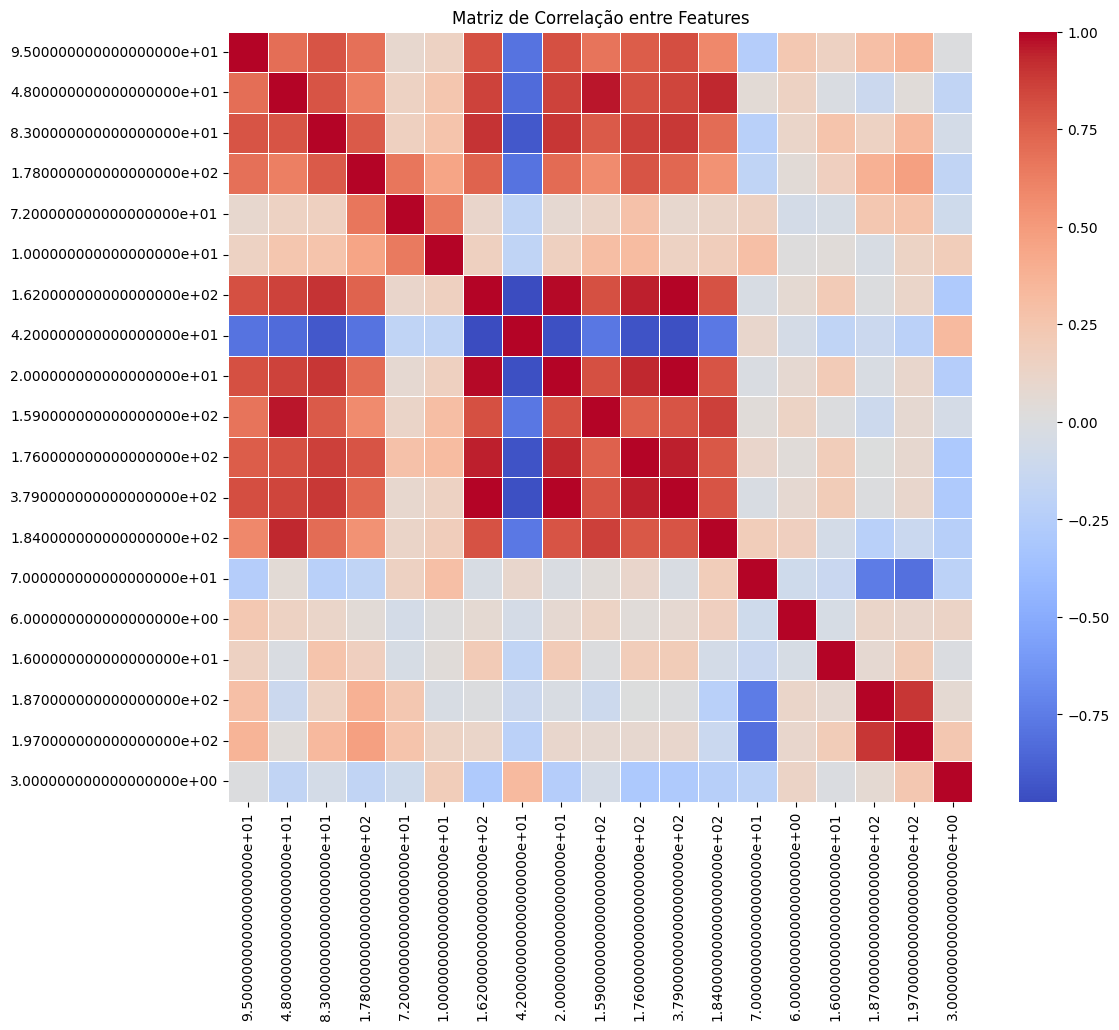

In [281]:
df = pd.read_csv('vehicle.csv')

# Calcula a matriz de correlação
correlation_matrix = df.corr()

# Exibe como heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Matriz de Correlação entre Features")
plt.show()

In [282]:
# Extrai pares com correlação alta (mas diferentes de 1)
threshold = 0.8
corr_pairs = correlation_matrix.abs().unstack()
high_corr = corr_pairs[(corr_pairs > threshold) & (corr_pairs < 1)].sort_values(ascending=False)

print("Pares com correlação alta:")
print(high_corr)

Pares com correlação alta:
1.620000000000000000e+02  3.790000000000000000e+02    0.996329
3.790000000000000000e+02  1.620000000000000000e+02    0.996329
2.000000000000000000e+01  3.790000000000000000e+02    0.992354
3.790000000000000000e+02  2.000000000000000000e+01    0.992354
2.000000000000000000e+01  1.620000000000000000e+02    0.992088
                                                        ...   
4.800000000000000000e+01  1.760000000000000000e+02    0.808940
1.970000000000000000e+02  7.000000000000000000e+01    0.805395
7.000000000000000000e+01  1.970000000000000000e+02    0.805395
1.620000000000000000e+02  1.840000000000000000e+02    0.801060
1.840000000000000000e+02  1.620000000000000000e+02    0.801060
Length: 62, dtype: float64


In [263]:
# Treina modelo Naive Bayes multiclasse
def train_naive_bayes_gaussian(X, y):
    classes = np.unique(y)
    
    priors = {}       # Probabilidades a priori P(y=c)
    means = {}        # Médias por classe e feature
    variances = {}    # Variâncias por classe e feature

    for c in classes:
        X_c = X[y == c]
        priors[c] = X_c.shape[0] / X.shape[0]
        means[c] = np.mean(X_c, axis=0)
        variances[c] = np.var(X_c, axis=0) + 1e-9  # Evita divisão por zero

    return priors, means, variances

In [254]:
# Predição com Naive Bayes
def predict_naive_bayes_gaussian(X, priors, means, variances):
    n_samples = X.shape[0]
    n_classes = len(priors)
    posteriors = np.zeros((n_samples, n_classes))

    for c in range(n_classes):
        prior = priors[c]
        mean = means[c]
        variance = variances[c]

        # Calcula a probabilidade de cada amostra pertencer à classe c
        likelihood = np.exp(-0.5 * ((X - mean) ** 2) / variance) / np.sqrt(2 * np.pi * variance)
        posterior = prior * np.prod(likelihood, axis=1)
        posteriors[:, c] = posterior

    return np.argmax(posteriors, axis=1)

In [259]:
# Cross-validation naive bayes multiclass
def cross_validation_naive_bayes_multiclass(X, y, k):
    acuracias_globais = []
    acuracias_por_classe = []
    
    for X_train, X_test, y_train, y_test in kfold(X, y, k):

        # Normaliza os dados
        X_train, mean, std = normaliza(X_train)
        X_test, mean, std = normaliza(X_test)

        # Adiciona o bias
        X_train = adicionar_bias(X_train)
        X_test = adicionar_bias(X_test)

        # Inicializa os pesos
        theta = np.zeros((X_train.shape[1], len(np.unique(y))))
        
        # Treina o modelo
        priors, means, variances = train_naive_bayes_gaussian(X_train, y_train)
        
        # Faz previsões
        y_pred = predict_naive_bayes_gaussian(X_test, priors, means, variances)
        
      # Acurácia global
        acuracia_global = np.mean(y_pred == y_test)
        acuracias_globais.append(acuracia_global)

        # Acurácia por classe
        classes = np.unique(y)
        acuracias_classe = []
        for c in classes:
            idx = (y_test == c)
            acuracia_c = np.mean(y_pred[idx] == y_test[idx])
            acuracias_classe.append(acuracia_c)
        acuracias_por_classe.append(acuracias_classe)

      # Converte para array para facilitar operações
    acuracias_por_classe = np.array(acuracias_por_classe)

    # Calcula estatísticas
    media_global = np.mean(acuracias_globais)
    desvio_global = np.std(acuracias_globais)

    media_por_classe = np.mean(acuracias_por_classe, axis=0)
    desvio_por_classe = np.std(acuracias_por_classe, axis=0)

    return media_global, desvio_global, media_por_classe, desvio_por_classe, acuracias_globais

In [ ]:
# Separa os dados em variáveis independentes e dependentes
X = veiculo_dataset[:, :-1]
y = veiculo_dataset[:, -1]

# Define os parâmetros
k = 10

# Executa a validação cruzada
media_g, desvio_g, media_classe, desvio_classe, acuracias_globais = cross_validation_naive_bayes_multiclass(X, y, k)

print(f"Acurácia global média: {media_g:.4f}")
print(f"Desvio padrão da acurácia global: {desvio_g:.4f}")

print("\n")

for i, (m, d) in enumerate(zip(media_classe, desvio_classe)):
    print(f"Acurácia média e desvio padrão da classe {i}: {m:.4f} (± {d:.4f})")
    
print("\n")

for i, acuracia in enumerate(acuracias_globais):
    print(f"Acurácia global para o fold {i}: {acuracia:.4f}")

Acurácia global média: 0.4546
Desvio padrão da acurácia global: 0.0775


Acurácia média e desvio padrão da classe 0: 0.2408 (± 0.0980)
Acurácia média e desvio padrão da classe 1: 0.4153 (± 0.0900)
Acurácia média e desvio padrão da classe 2: 0.3381 (± 0.1173)
Acurácia média e desvio padrão da classe 3: 0.8718 (± 0.0794)


Acurácia global para o fold 0: 0.4471
Acurácia global para o fold 1: 0.4471
Acurácia global para o fold 2: 0.3412
Acurácia global para o fold 3: 0.4118
Acurácia global para o fold 4: 0.4824
Acurácia global para o fold 5: 0.5476
Acurácia global para o fold 6: 0.5357
Acurácia global para o fold 7: 0.5833
Acurácia global para o fold 8: 0.3690
Acurácia global para o fold 9: 0.3810
